#### http://mmlab.ie.cuhk.edu.hk/archive/2011/Haze.pdf (Single Image Haze Removal Using Dark Channel Prior)

#### https://ieeexplore.ieee.org/abstract/document/9071296?casa_token=jK0mQtbsmY8AAAAA:N2MSJmhXzS0Gvy4VA2LQPGahflGEW-1ZeZj75VfQndf8UuLMpNYFIem3DVyZUBuzu8bNSCMue1b9

In [1]:
#!nvidia-smi

In [2]:
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import math
import copy

from scipy import ndimage
from skimage.metrics import peak_signal_noise_ratio
from numpy import linalg as LA

In [3]:

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [4]:
!ls -lrt /content/drive/MyDrive/CV_Project/Dataset

total 5406431
-rw------- 1 root root  434661527 May  9 17:48 SOTS.zip
-rw------- 1 root root    7160851 May  9 17:49 HSTS.zip
-rw------- 1 root root 5094361262 May  9 20:07 archive.zip


In [5]:
#!mkdir ITS
!mkdir SOTS
#!cp /content/drive/MyDrive/CV_Project/Dataset/archive.zip ./ITS/
!cp /content/drive/MyDrive/CV_Project/Dataset/SOTS.zip ./SOTS/

In [6]:
#!unzip -qq ./ITS/archive.zip
!unzip -qq ./SOTS/SOTS.zip

In [7]:
!ls -lrt /content/SOTS/outdoor/

!rm -rf /content/SOTS/outdoor/hazy/0051_0.95_0.12.jpg
!rm -rf /content/SOTS/outdoor/hazy/0076_1_0.16.jpg
!rm -rf /content/SOTS/outdoor/hazy/0086_0.95_0.12.jpg
!rm -rf /content/SOTS/outdoor/hazy/0108_1_0.2.jpg
!rm -rf /content/SOTS/outdoor/hazy/0253_1_0.16.jpg
!rm -rf /content/SOTS/outdoor/hazy/0287_0.95_0.08.jpg
!rm -rf /content/SOTS/outdoor/hazy/0330_0.8_0.08.jpg
!rm -rf /content/SOTS/outdoor/hazy/0320_0.9_0.08.jpg

total 32
drwxr-xr-x 2 root root 20480 Dec 23  2017 hazy
drwxr-xr-x 2 root root 12288 Dec 23  2017 gt


In [8]:
path_id_hz = Path('/content/SOTS/indoor/hazy/')
path_id_gt = Path('/content/SOTS/indoor/gt/')

path_od_hz = Path('/content/SOTS/outdoor/hazy/')
path_od_gt = Path('/content/SOTS/outdoor/gt/')

def gen_image_list(path):
  img_path_list = [img_path for img_path in path.iterdir()]
  img_list_bgr = [cv2.imread(str(img_path)) for img_path in sorted(img_path_list)]
  img_list = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in img_list_bgr]
  return img_list


In [9]:
img_list_id_hz = gen_image_list(path_id_hz)
img_list_id_gt = gen_image_list(path_id_gt)

img_list_od_hz = gen_image_list(path_od_hz)
img_list_od_gt = gen_image_list(path_od_gt)

In [10]:
def plot_images(img_list, title):
  fig = plt.figure(figsize=(30, 10))
  for pos, ip_img in enumerate(img_list):
    ax = fig.add_subplot(2, 10//2, pos+1)
    plt.imshow(ip_img, cmap='gray')
  fig.suptitle(title, fontsize=30)
  fig.subplots_adjust(top=0.95)

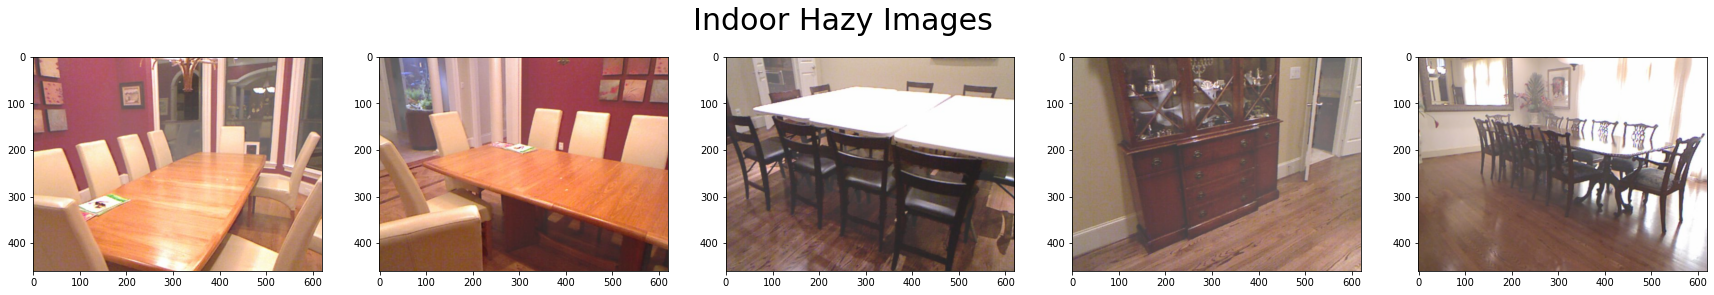

In [11]:
plot_images(img_list_id_hz[0:50:10], 'Indoor Hazy Images')

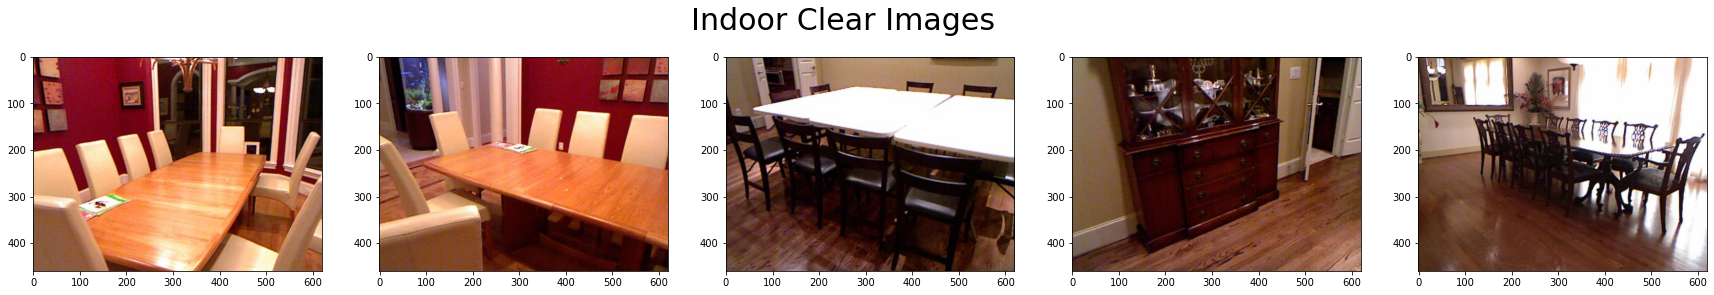

In [12]:
plot_images(img_list_id_gt[0:5], 'Indoor Clear Images')

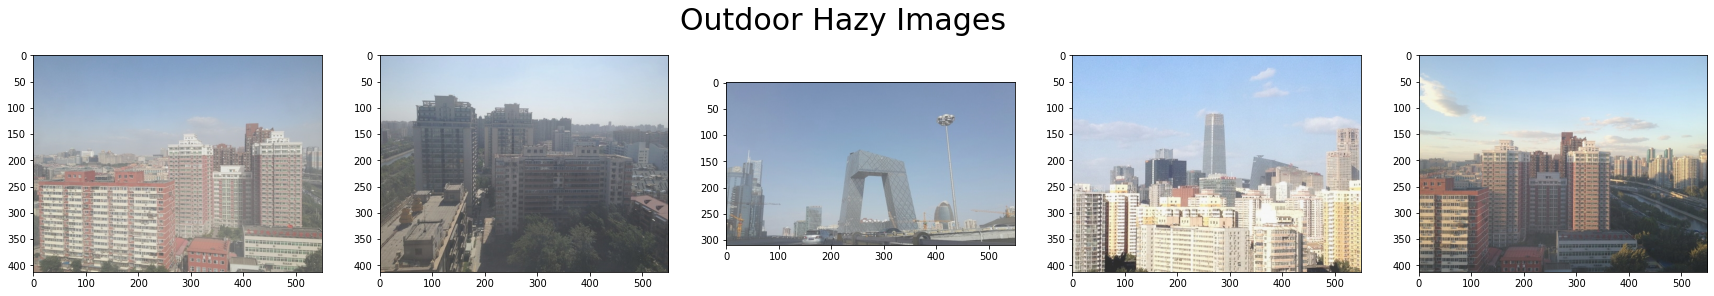

In [13]:
plot_images(img_list_od_hz[0:5], 'Outdoor Hazy Images')

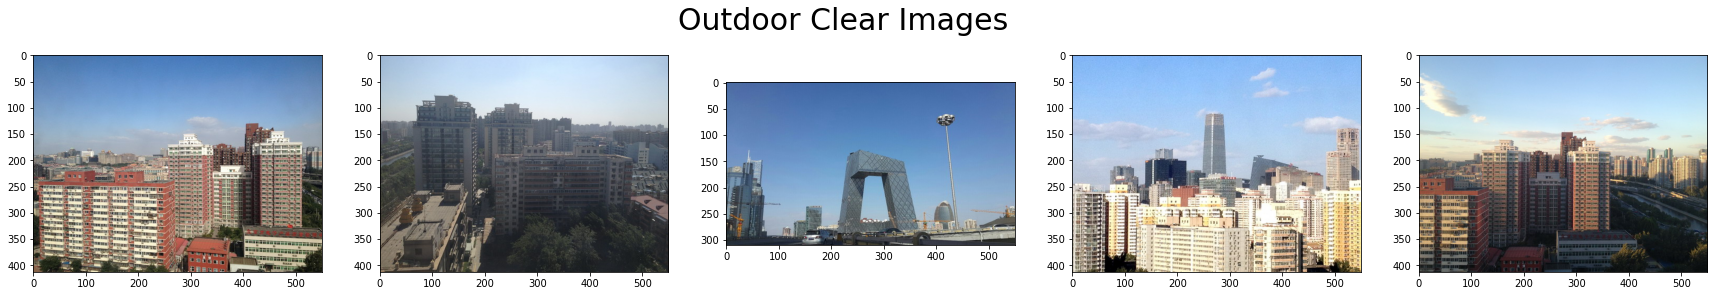

In [14]:
plot_images(img_list_od_gt[0:5], 'Outdoor Clear Images')

### Haze Removal Using Dark Channel Prior

In [15]:
def get_dark_channel(img_array, size = (15,15)):
  #dark_channel = np.zeros([img_array.shape[0], img_array.shape[1]])
  min_channels = np.amin(img_array, axis = 2 )
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, size)
  dark_channel = cv2.erode(min_channels, kernel)
  return dark_channel

In [16]:
def get_atmospheric_light(img_array, dark_channel, threshold = 0.1):
  num_largest = int(threshold * dark_channel.shape[0] * dark_channel.shape[1])
  indices = (-dark_channel.astype('int64')).argpartition(num_largest, axis=None)[:num_largest]
  x, y = np.unravel_index(indices, dark_channel.shape)
  r_pixels = [img_array[row,col,0] for row,col in zip(x,y)]
  g_pixels = [img_array[row,col,1] for row,col in zip(x,y)]
  b_pixels = [img_array[row,col,2] for row,col in zip(x,y)]
  return np.amax(r_pixels),np.amax(g_pixels),np.amax(b_pixels)
  

In [17]:
def get_transmission_map(img_array, A_r, A_g, A_b, weight = 0.95, size = (15,15), diameter = 10):
  img_array_normalized = np.zeros([img_array.shape[0], img_array.shape[1], img_array.shape[2]])
  img_array_normalized[:,:,0] = img_array[:,:,0] / A_r
  img_array_normalized[:,:,1] = img_array[:,:,1] / A_g
  img_array_normalized[:,:,2] = img_array[:,:,2] / A_b
  dark_channel_img_array_normalized = get_dark_channel(img_array_normalized, size)
  trans_map = 1 - weight * dark_channel_img_array_normalized
  trans_map_sm = cv2.bilateralFilter(trans_map.astype('float32'),diameter,75,75)
  return trans_map,trans_map_sm

In [18]:
def process_haze(img_array, A_r, A_g, A_b, trans_map, t_0 = 0.1):
  dhazed_img = np.zeros([img_array.shape[0], img_array.shape[1], img_array.shape[2]])
  dhazed_img[:,:,0] = (img_array[:,:,0].astype('float64') - A_r)/max(np.amax(trans_map.astype('float64')), 0.1) + A_r
  dhazed_img[:,:,1] = (img_array[:,:,1].astype('float64') - A_g)/max(np.amax(trans_map.astype('float64')), 0.1) + A_r
  dhazed_img[:,:,2] = (img_array[:,:,2].astype('float64') - A_b)/max(np.amax(trans_map.astype('float64')), 0.1) + A_r
  return dhazed_img.astype('uint8')

In [19]:
def dehaze(img_array, size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1):
  dark_channel = get_dark_channel(img_array, size)
  A_r,A_g,A_b = get_atmospheric_light(img_array, dark_channel, threshold)
  trans_map,trans_map_sm = get_transmission_map(img_array, A_r, A_g, A_b, weight, size, diameter)
  dehazed_img = process_haze(img_array, A_r, A_g, A_b, trans_map_sm, t_0)
  return dehazed_img

In [49]:
def dehaze_pipeline1(img_array, size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1, sat_thresh = 0.1):
  # Perform white balance on input image (Preprocess)
  wb = cv2.xphoto.createGrayworldWB()
  wb.setSaturationThreshold(sat_thresh)
  img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
  img_array_wb = wb.balanceWhite(img_array)
  img_array_wb = cv2.cvtColor(img_array_wb, cv2.COLOR_BGR2RGB)

  # Perform dehazing on wb input image
  dehazed_img = dehaze(img_array_wb, size)
  #return dehazed_img

  # Perform CLAHE (Postprocess)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  dehazed_img = cv2.cvtColor(dehazed_img, cv2.COLOR_RGB2BGR)
  lab = cv2.cvtColor(dehazed_img, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  lab[:,:,0] = clahe.apply(lab[:,:,0])
  dehazed_img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  dehazed_img_clahe = cv2.cvtColor(dehazed_img_clahe, cv2.COLOR_BGR2RGB)
  return dehazed_img_clahe

In [21]:
!pip install PyWavelets

In [22]:
def sub_band_smooth_filter(size = (3,3), sub_band = None):
  """
  Returns a filtered sub band

  This functions applies filter to the given sub band

  Parameters
  ----------

  size : tuple
       This represents the size of the smoothing filter.
  sub_band : ndarray
       This is a sub_band array. This can be any component obtained after performing DWT on a given image.

  Returns
  -------

  out : ndarray
      The function returns processed ndarray representing the smoothed sub_band
  """
  if sub_band is not None:
    pad_length = math.ceil((size[0] - 1)/2) # Calculate the amount of padding for output image size to be same as that of input image
    img_pad = np.pad(sub_band, pad_length, 'constant').astype(dtype = np.float64) # Apply zero padding
    out_arr = np.zeros_like(sub_band, dtype = np.float64) #  Create ndarray of all zeros with the same size as that of input image

    mask = np.ones(size,dtype = np.float64) # Mask of all ones
    for row_element in range(out_arr.shape[0]):
      for col_element in range(out_arr.shape[1]):
          mult_array = np.multiply(img_pad[row_element : row_element + size[0], col_element : col_element + size[0]] , mask) # Perform element-wise multiplication with the mask
          #print(np.sum(mult_array)/(size[0]*size[1]))
          out_arr[row_element, col_element] = ((np.sum(mult_array))/(size[0]*size[1])).astype(dtype = np.float64) # Obtain the average of all elements from previous step and update the the output array
    return out_arr
  else:
    print("No sub band to perform filter operation")
    return

In [52]:
import pywt

smooth = lambda input_sub_band: sub_band_smooth_filter(size = (5,5), sub_band = input_sub_band)

def dehaze_pipeline2(img_array, size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1, sat_thresh = 0.1):
  # Perform white balance on input image (Preprocess)
  wb = cv2.xphoto.createGrayworldWB()
  wb.setSaturationThreshold(sat_thresh)
  img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
  img_array_wb = wb.balanceWhite(img_array)
  img_array_wb = cv2.cvtColor(img_array_wb, cv2.COLOR_BGR2RGB)

  # Perform dehazing on wb input image
  dehazed_img = dehaze(img_array_wb, size)
  #return dehazed_img

  # Perform CLAHE (Postprocess)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  dehazed_img = cv2.cvtColor(dehazed_img, cv2.COLOR_RGB2BGR)
  lab = cv2.cvtColor(dehazed_img, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  lab[:,:,0] = clahe.apply(lab[:,:,0])
  dehazed_img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  dehazed_img_clahe = cv2.cvtColor(dehazed_img_clahe, cv2.COLOR_BGR2RGB)
  #return dehazed_img_clahe


  haar = pywt.Wavelet('haar')
  haar_coeffs2_0 = pywt.dwt2(dehazed_img_clahe[:,:,0], 'haar')
  haar_coeffs2_1 = pywt.dwt2(dehazed_img_clahe[:,:,1], 'haar')
  haar_coeffs2_2 = pywt.dwt2(dehazed_img_clahe[:,:,2], 'haar')
  LL_haar_0, (LH_haar_0, HL_haar_0, HH_haar_0) = haar_coeffs2_0
  LL_haar_1, (LH_haar_1, HL_haar_1, HH_haar_1) = haar_coeffs2_1
  LL_haar_2, (LH_haar_2, HL_haar_2, HH_haar_2) = haar_coeffs2_2

  #LL_haar = np.stack((smooth(LL_haar_0), smooth(LL_haar_1), smooth(LL_haar_2)), axis=2)
  #print(LL_haar.dtype)



  enhanced_img_0 = pywt.idwt2((LL_haar_0, (smooth(LH_haar_0), smooth(HL_haar_0), smooth(HH_haar_0))), 'haar')
  enhanced_img_1 = pywt.idwt2((LL_haar_1, (smooth(LH_haar_1), smooth(HL_haar_1), smooth(HH_haar_1))), 'haar')
  enhanced_img_2 = pywt.idwt2((LL_haar_2, (smooth(LH_haar_2), smooth(HL_haar_2), smooth(HH_haar_2))), 'haar')
  enhanced_img = np.stack((enhanced_img_0, enhanced_img_1, enhanced_img_2), axis=2)
  return enhanced_img.astype('uint8')


Text(0.5, 1.0, 'Original Hazy Image')

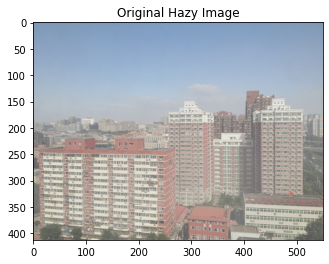

In [24]:
plt.imshow(img_list_od_hz[0])
plt.title("Original Hazy Image")

Text(0.5, 1.0, 'Dehazed Image (Without any processing)')

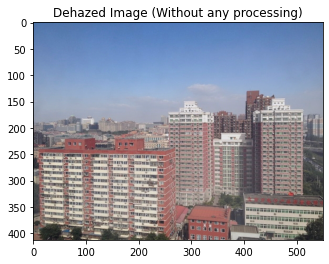

In [25]:
dehazed_just_img = dehaze(img_list_od_hz[0], size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1)

plt.imshow(dehazed_just_img)
plt.title("Dehazed Image (Without any processing)")

Text(0.5, 1.0, 'Dehazed Image (Preprocess : WB, Postprocess : CLAHE)')

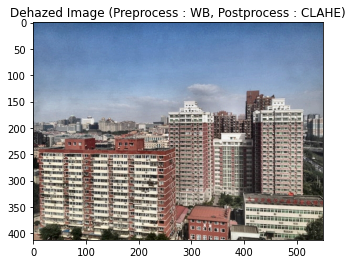

In [50]:
dehazed_preprocess_img = dehaze_pipeline1(img_list_od_hz[0], size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1, sat_thresh = 0.1)

plt.imshow(dehazed_preprocess_img)
plt.title("Dehazed Image (Preprocess : WB, Postprocess : CLAHE)") # Contrast Limited Adaptive Histogram Equalization

Text(0.5, 1.0, 'Dehazed Image (Preprocess : WB, Postprocess : CLAHE, DWT)')

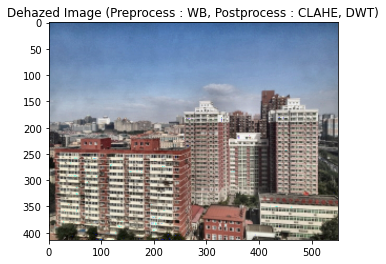

In [53]:
dehazed_dwt_img = dehaze_pipeline2(img_list_od_hz[0], size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1, sat_thresh = 0.1)
plt.imshow(dehazed_dwt_img)
plt.title("Dehazed Image (Preprocess : WB, Postprocess : CLAHE, DWT)") # Contrast Limited Adaptive Histogram Equalization and DWT (Smoothing HL,LH and HH of Haar Sub-bands)

Text(0.5, 1.0, 'Original Un-Hazy Image')

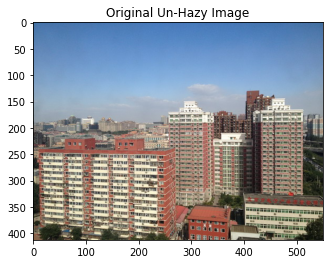

In [28]:
plt.imshow(img_list_od_gt[0])
plt.title("Original Un-Hazy Image")

### PSNR & SSIM

In [64]:
from skimage.metrics import peak_signal_noise_ratio

from skimage.metrics import structural_similarity

def calc_avg_psnr(gt_list, hz_list, lambda_func, flag = 'id'):
  psnr_list = []
  ssim_list = []
  if flag == 'id':
    for idx,item in enumerate(hz_list):
      dehazed_img = lambda_func(item)
      gt_img = gt_list[int(idx/10)]
      psnr_val = peak_signal_noise_ratio(gt_img, dehazed_img[0:gt_img.shape[0], 0:gt_img.shape[1], :])
      psnr_list.append(psnr_val)
      ssim_val = structural_similarity(gt_img, dehazed_img[0:gt_img.shape[0], 0:gt_img.shape[1], :], multichannel = True)
      ssim_list.append(ssim_val)
  if flag == 'od':
    for idx,item in enumerate(hz_list):
      dehazed_img = lambda_func(item)
      gt_img = gt_list[int(idx/1)]
      #print(dehazed_img.shape)
      #print(gt_img.shape)
      psnr_val = peak_signal_noise_ratio(gt_img, dehazed_img[0:gt_img.shape[0], 0:gt_img.shape[1], :])
      psnr_list.append(psnr_val)
      ssim_val = structural_similarity(gt_img, dehazed_img[0:gt_img.shape[0], 0:gt_img.shape[1], :], multichannel = True)
      ssim_list.append(ssim_val)
  return np.mean(psnr_list), np.mean(ssim_list)



In [65]:
lambda_func_dehaze = lambda x: dehaze(x, size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1)

lambda_func_dehaze_pipeline1 = lambda x: dehaze_pipeline1(x, size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1, sat_thresh = 0.1)

lambda_func_dehaze_pipeline2 = lambda x: dehaze_pipeline2(x, size = (15,15), threshold = 0.1, weight = 0.95, diameter = 10, t_0 = 0.1, sat_thresh = 0.1)

### SOTS Indoor - PSNR, SSIM

In [66]:
psnr_id_dehaze, ssim_id_dehaze = calc_avg_psnr(img_list_id_gt, img_list_id_hz, lambda_func_dehaze, flag = 'id')

psnr_id_dehaze_pl1, ssim_id_dehaze_pl1 = calc_avg_psnr(img_list_id_gt, img_list_id_hz, lambda_func_dehaze_pipeline1, flag = 'id')

psnr_id_dehaze_pl2, ssim_id_dehaze_pl2 = calc_avg_psnr(img_list_id_gt, img_list_id_hz, lambda_func_dehaze_pipeline2, flag = 'id')

In [67]:
print("Average PSNR for SOTS Indoor Images Dehazed with DCP :", psnr_id_dehaze)
print("Average PSNR for SOTS Indoor Images Dehazed with DCP with Preprocessing(Pipeline1) :", psnr_id_dehaze_pl1)
print("Average PSNR for SOTS Indoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) :", psnr_id_dehaze_pl2)


print("Average SSIM for SOTS Indoor Images Dehazed with DCP :", ssim_id_dehaze)
print("Average SSIM for SOTS Indoor Images Dehazed with DCP with Preprocessing(Pipeline1) :", ssim_id_dehaze_pl1)
print("Average SSIM for SOTS Indoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) :", ssim_id_dehaze_pl2)

Average PSNR for SOTS Indoor Images Dehazed with DCP : 14.91212226619612
Average PSNR for SOTS Indoor Images Dehazed with DCP with Preprocessing(Pipeline1) : 15.088614455629532
Average PSNR for SOTS Indoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) : 14.898261597476749
Average SSIM for SOTS Indoor Images Dehazed with DCP : 0.7808506442597811
Average SSIM for SOTS Indoor Images Dehazed with DCP with Preprocessing(Pipeline1) : 0.7487565257993833
Average SSIM for SOTS Indoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) : 0.7091964054242976


### SOTS Outdoor - PSNR, SSIM

In [68]:
psnr_od_dehaze, ssim_id_dehaze = calc_avg_psnr(img_list_od_gt, img_list_od_hz, lambda_func_dehaze, flag = 'od')

psnr_od_dehaze_pl1, ssim_id_dehaze_pl1 = calc_avg_psnr(img_list_od_gt, img_list_od_hz, lambda_func_dehaze_pipeline1, flag = 'od')

psnr_od_dehaze_pl2, ssim_id_dehaze_pl2 = calc_avg_psnr(img_list_od_gt, img_list_od_hz, lambda_func_dehaze_pipeline2, flag = 'od')

In [69]:
print("Average PSNR for SOTS Outdoor Images Dehazed with DCP :", psnr_od_dehaze)
print("Average PSNR for SOTS Outdoor Images Dehazed with DCP with Preprocessing(Pipeline1) :", psnr_od_dehaze_pl1)
print("Average PSNR for SOTS Outdoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) :", psnr_od_dehaze_pl2)


print("Average SSIM for SOTS Outdoor Images Dehazed with DCP :", ssim_id_dehaze)
print("Average SSIM for SOTS Outdoor Images Dehazed with DCP with Preprocessing(Pipeline1) :", ssim_id_dehaze_pl1)
print("Average SSIM for SOTS Outdoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) :", ssim_id_dehaze_pl2)

Average PSNR for SOTS Outdoor Images Dehazed with DCP : 21.9988773393858
Average PSNR for SOTS Outdoor Images Dehazed with DCP with Preprocessing(Pipeline1) : 18.558668056069813
Average PSNR for SOTS Outdoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) : 18.076255938198056
Average SSIM for SOTS Outdoor Images Dehazed with DCP : 0.9086461333139355
Average SSIM for SOTS Outdoor Images Dehazed with DCP with Preprocessing(Pipeline1) : 0.8236948048114106
Average SSIM for SOTS Outdoor Images Dehazed with DCP with both Preprocessing and Postprocessing(Pipeline2) : 0.7580779204529856


In [55]:
img_list_id_dehaze = [lambda_func_dehaze(image) for image in img_list_id_hz[0:55]]
img_list_id_dehaze_pl1  = [lambda_func_dehaze_pipeline1(image) for image in img_list_id_hz[0:55]]
img_list_id_dehaze_pl2   = [lambda_func_dehaze_pipeline2(image) for image in img_list_id_hz[0:55]]

In [56]:
img_list_od_dehaze = [lambda_func_dehaze(image) for image in img_list_od_hz[0:7]]
img_list_od_dehaze_pl1  = [lambda_func_dehaze_pipeline1(image) for image in img_list_od_hz[0:7]]
img_list_od_dehaze_pl2   = [lambda_func_dehaze_pipeline2(image) for image in img_list_od_hz[0:7]]

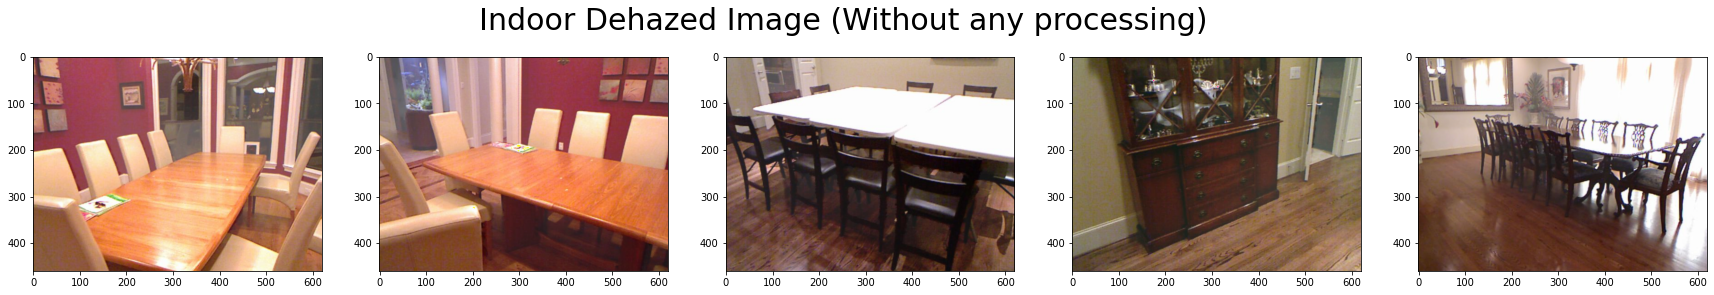

In [57]:
plot_images(img_list_id_dehaze[0:50:10], 'Indoor Dehazed Image (Without any processing)')

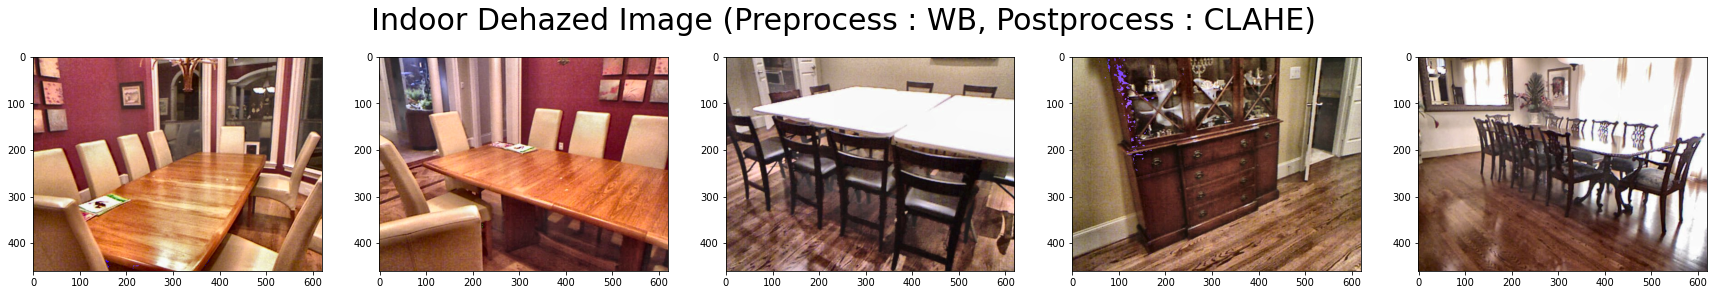

In [58]:
plot_images(img_list_id_dehaze_pl1[0:50:10], 'Indoor Dehazed Image (Preprocess : WB, Postprocess : CLAHE)')

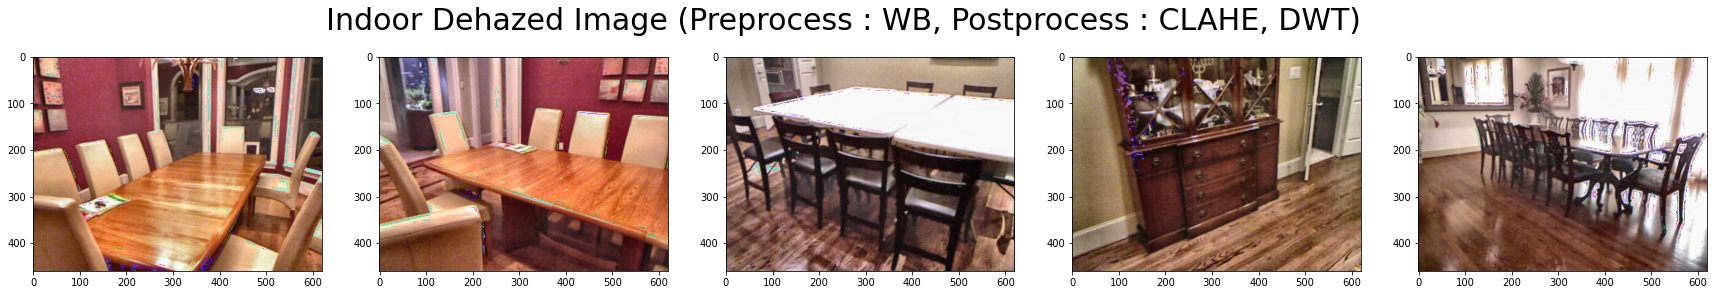

In [59]:
plot_images(img_list_id_dehaze_pl2[0:50:10], 'Indoor Dehazed Image (Preprocess : WB, Postprocess : CLAHE, DWT)')

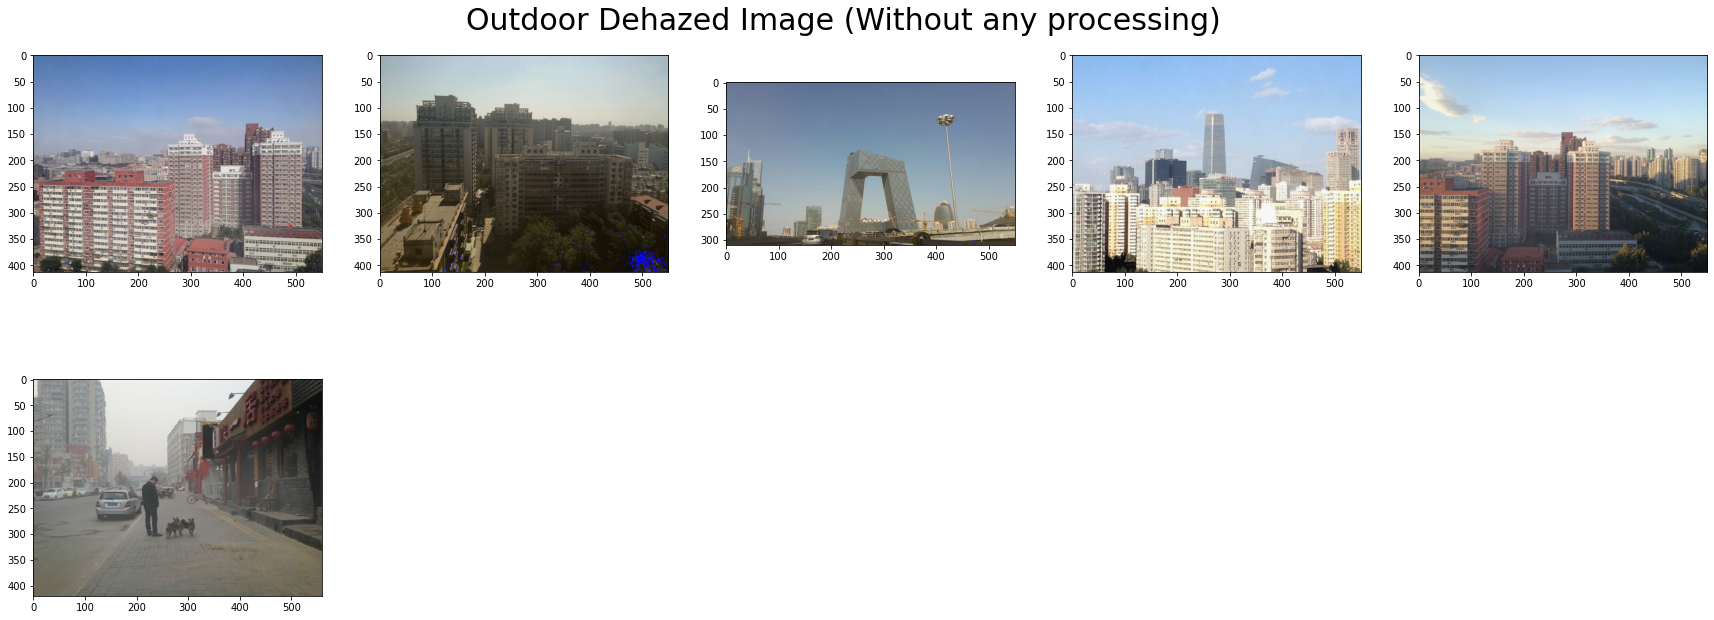

In [60]:
plot_images(img_list_od_dehaze[0:6], 'Outdoor Dehazed Image (Without any processing)')

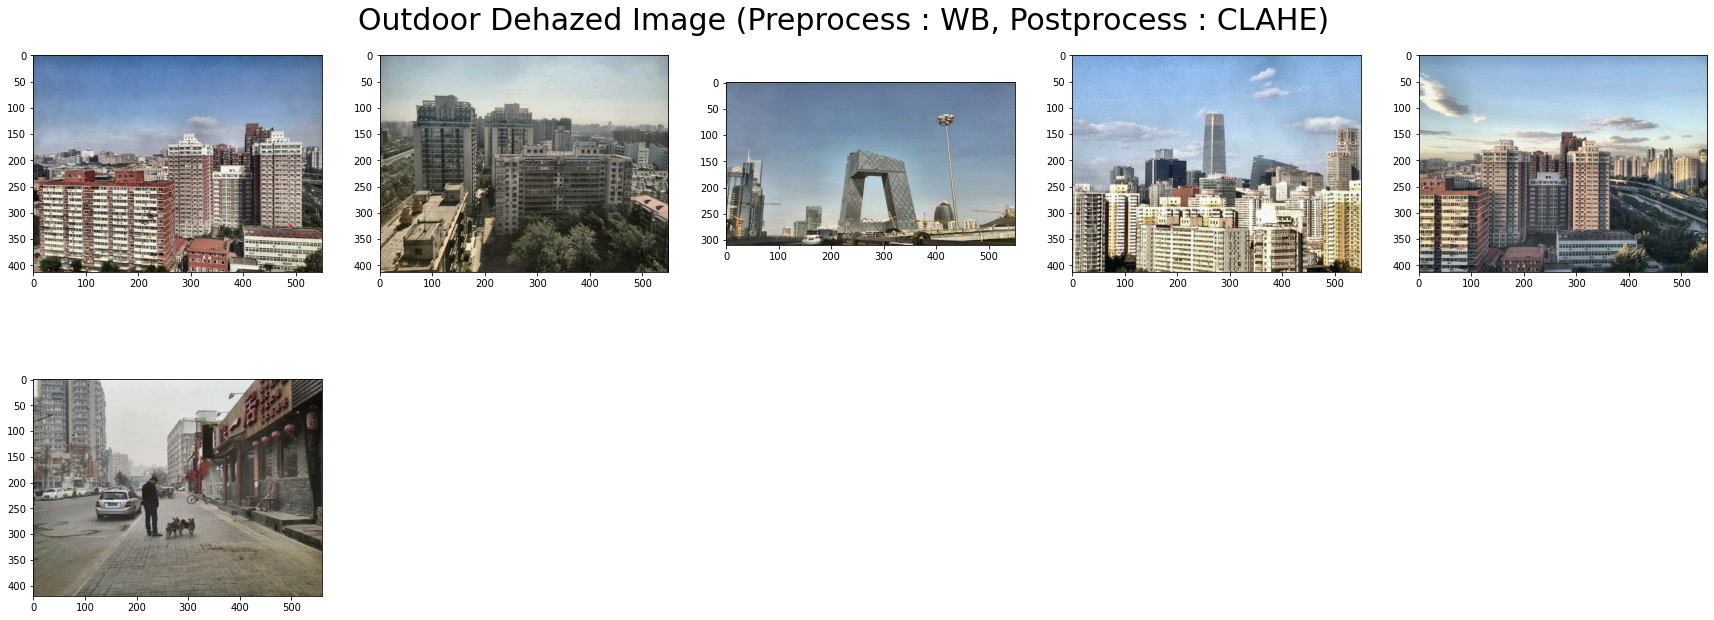

In [61]:
plot_images(img_list_od_dehaze_pl1[0:6], 'Outdoor Dehazed Image (Preprocess : WB, Postprocess : CLAHE)')

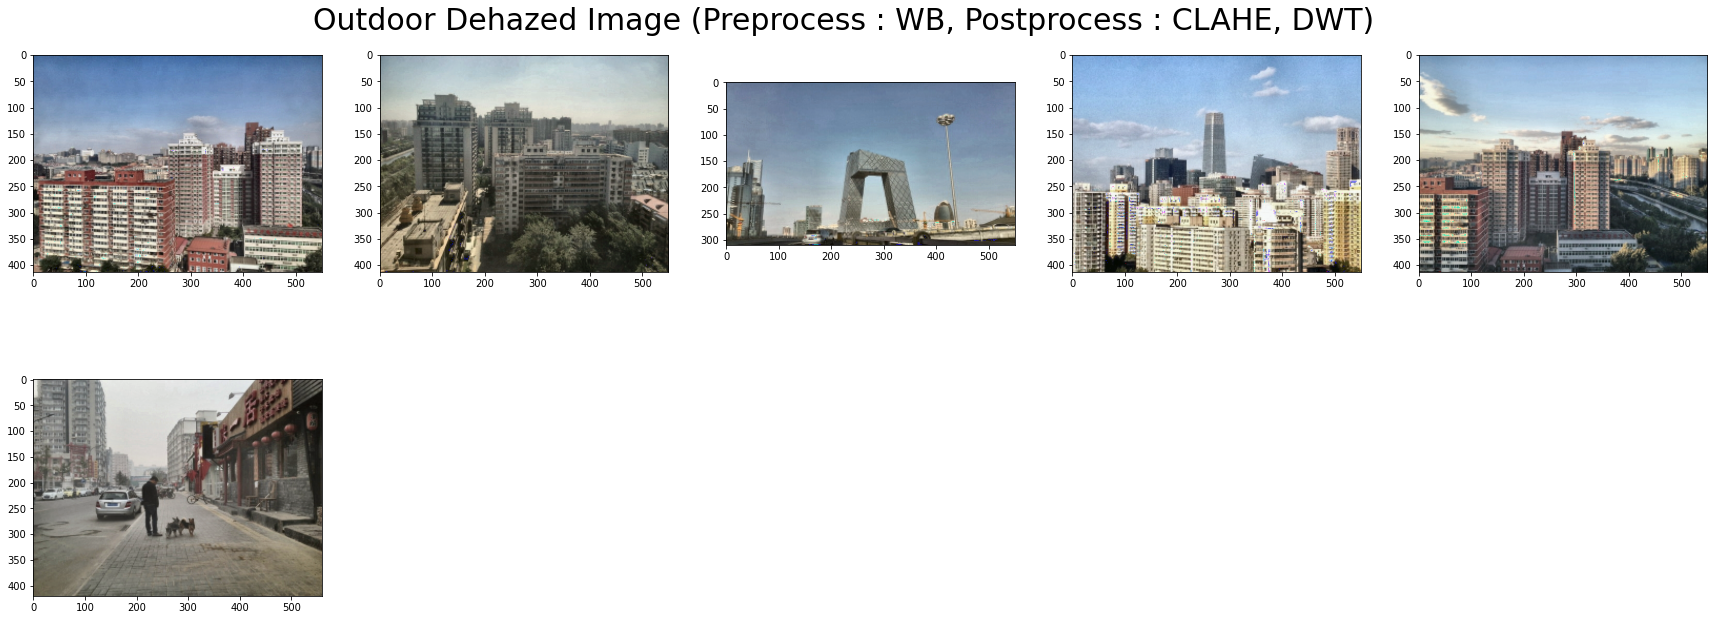

In [63]:
plot_images(img_list_od_dehaze_pl2[0:6], 'Outdoor Dehazed Image (Preprocess : WB, Postprocess : CLAHE, DWT)')

### Gaussian Pyramid - DID NOT WORK

In [ ]:
# generate Gaussian pyramid for A
G = img_list_od_hz[0].copy()
gpA = [G]
for i in range(6):
    G = cv2.pyrDown(G)
    L = dehaze(G, size = (15,15))
    gpA.append(G)

In [ ]:
# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv2.pyrUp(gpA[i])
    #print(gpA[i-1].shape)
    #print(GE.shape)
    L = cv2.subtract(gpA[i-1],GE[0:gpA[i-1].shape[0], 0:gpA[i-1].shape[1], 0:gpA[i-1].shape[2]])
    #L = dehaze(L, size = (15,15))
    lpA.append(L)

In [ ]:
# now reconstruct

ls_ = lpA[0]
for i in range(1,6):
    ls_ = cv2.pyrUp(ls_)
    #print(ls_.shape)
    #print(LS[i].shape)
    ls_ = cv2.add(ls_[0:LS[i].shape[0], 0:LS[i].shape[1], 0:LS[i].shape[2]], LS[i])

Text(0.5, 1.0, 'Output - Gaussian Pyramid + Dehaze at each step')

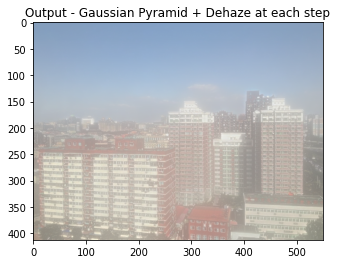

In [ ]:
plt.imshow(ls_)
plt.title("Output - Gaussian Pyramid + Dehaze at each step")

Text(0.5, 1.0, 'Origina Hazy Image')

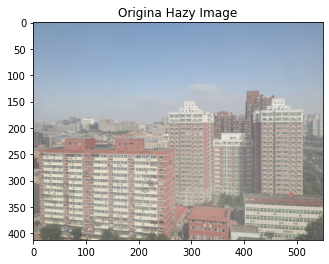

In [ ]:
plt.imshow(img_list_od_hz[0])
plt.title("Origina Hazy Image")